# Kronecker Structured Covariance

PyMC3 contains implementations for models that have Kronecker structured covariances.  This patterned structure enables Gaussian process models to work on much larger datasets.  Kronecker structure can be exploited when
- The dimension of the input data is greater than two ($\mathbf{x} \in \mathbb{R}^{d}\,, d > 2$)
- The influence of the process across each dimension is *separable*
- The kernel can be written as a product over dimension, without cross terms:

$$k(\mathbf{x}, \mathbf{x'}) = \prod_{i = 1}^{d} k(\mathbf{x}_{i}, \mathbf{x'}_i) \,.$$

The covariance matrix that corresponds to the covariance function above can be written with a *Kronecker product*

$$
\mathbf{K} = \mathbf{K}_2 \otimes \mathbf{K}_2 \otimes \cdots \otimes \mathbf{K}_d \,.
$$

These implementations support the following property of Kronecker products to speed up calculations, $(\mathbf{K}_1 + \mathbf{K}_2)^{-1} = \mathbf{K}_{1}^{-1} + \mathbf{K}_{2}^{-1}$, the inverse of the sum is the sum of the inverses.

This structure is common in spatial and image data for example, or perhaps time series data that has covariates.  Given that there Kronecker structure in the covariance matrix, this implementation is exact --- not an approximation to the full Gaussian process.  PyMC3 contains two implementations that follow the same pattern as `gp.Marginal` and `gp.Latent`.  For Kronecker structured covariances where the data likelihood is Gaussian, use `gp.MarginalKron`.  For Kronecker structured covariances where the data likelihood is non-Gaussian, use `gp.KroneckerLatent`.

## `MarginalKron`

The following is a canonical example of the usage of `MarginalKron`.  For the simulated data set, we draw one sample from a Gaussian process whose covariance is Kronecker structured.  Then we use `MarginalKron` to recover the unknown Gaussian process hyperparameters $\theta$ that were used to simulate the data.

### Simulate data

We'll simulate a data set with two dimensional inputs, and display it as a heatmap.  This could be a spatial dataset, for instance.

In [1]:
import sys
sys.path.insert(0, "/home/bill/packages/pymc3/")

import pymc3 as pm
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)

/home/bill/anaconda3/envs/pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [53]:
# One dimensional column vectors of inputs
n1, n2 = (50, 30)
x1 = np.linspace(0, 5, n1)
x2 = np.linspace(0, 3, n2)

# make cartesian grid out of each dimension x1 and x2
X = pm.math.cartesian(x1[:,None], x2[:,None])

l1_true = 1.0
l2_true = 0.5
eta_true = 0.5

# Although we could, we don't exploit kronecker structure to draw the sample
cov = eta_true**2 * pm.gp.cov.Matern32(2, l1_true, active_dims=[0]) *\
                    pm.gp.cov.Matern32(2, l2_true, active_dims=[1])

K = cov(X).eval()
f = np.random.multivariate_normal(np.zeros(X.shape[0]), K, 1).flatten()

sigma_true = 0.1
y = f + sigma_true * np.random.randn(X.shape[0])

So that the spatial correlation is visible, we plot the datapoints as squares (colored by magnitude) on a black background.  Since the lengthscale along the `x1` dimension is longer than the lengthscale along the `x2` direction (`l1_true` > `l2_true`), there is noticibly less variation along `x1` than along `x2`.

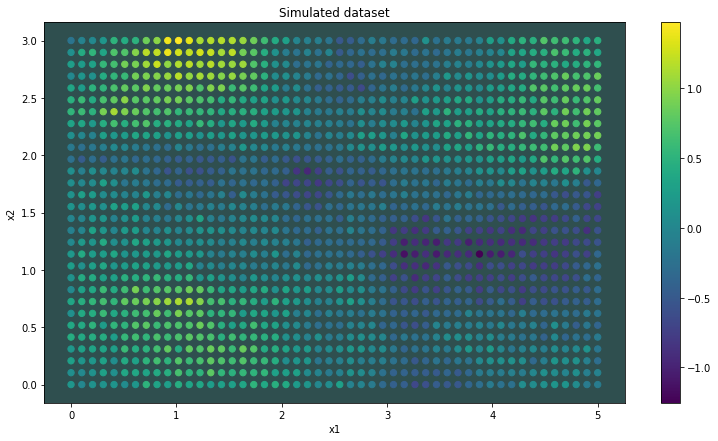

In [54]:
fig = plt.figure(figsize=(13,7))
ax = fig.gca(); ax.set_facecolor("darkslategrey")
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='o'); plt.colorbar();
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("Simulated dataset");

There are 1500 data points in this data set.  Without using the factorization, finding the MAP estimate would be much slower.

**Since the two covariances are a product, only scale one of them.**

In [55]:
# this implementation takes a list of inputs for each dimension as input
Xs = [x1[:,None], x2[:,None]]

with pm.Model() as model:
    # Set priors on the hyperparameters of the covariance
    ls1 = pm.Gamma("ls1", alpha=2, beta=0.5)
    ls2 = pm.Gamma("ls2", alpha=2, beta=0.5)
    eta = pm.HalfNormal("eta", sd=5)
    
    # Specify the covariance functions for each Xi
    cov_x1 = eta**2 * pm.gp.cov.ExpQuad(1, ls=ls1)  # Must accept X1 without error
    cov_x2 = pm.gp.cov.ExpQuad(1, ls=ls2)           # Must accept X2 without error

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.MarginalKron(cov_funcs=[cov_x1, cov_x2])

    # Set the prior on the variance for the Gaussian noise
    sigma = pm.HalfNormal("sigma", sd=5)
    
    # Place a GP prior over the function f.
    y_ = gp.marginal_likelihood("y", Xs=Xs, y=y, sigma=sigma)

with model:
    mp = pm.find_MAP()

logp = 915.12, ||grad|| = 10.641: 100%|██████████| 96/96 [00:08<00:00, 11.09it/s]  


In [56]:
mp

{'ls1_log__': array(-0.94345889),
 'ls2_log__': array(-1.47755293),
 'eta_log__': array(-1.07484795),
 'sigma_log__': array(-2.25929044),
 'ls1': array(0.38927903),
 'ls2': array(0.22819542),
 'eta': array(0.34134965),
 'sigma': array(0.10442455)}

In [57]:
x1new = np.linspace(5.1, 6.1, 10)
x2new = np.linspace(0, 3, 30)
Xsnew = pm.math.cartesian(x1new[:,None], x2new[:,None])

mu, var = gp.predict(Xsnew, point=mp, diag=False)

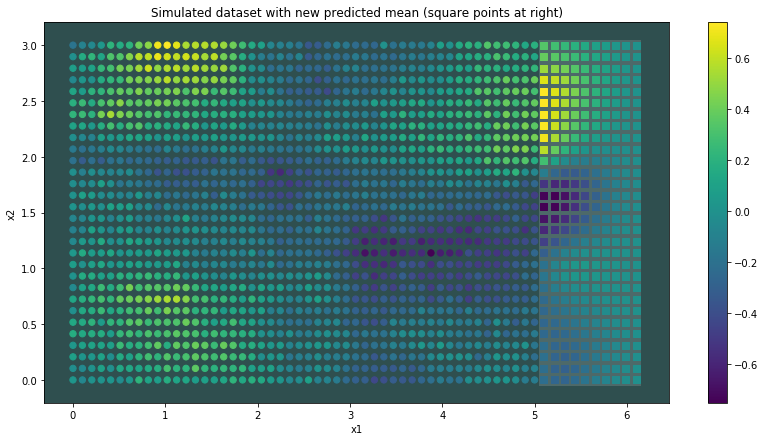

In [58]:
fig = plt.figure(figsize=(14,7))
ax = fig.gca(); ax.set_facecolor("darkslategrey")
ax.add_patch(plt.Rectangle((5.05, -0.05), 1.1, 3.1, facecolor="w", alpha=0.15, zorder=-1))
plt.scatter(X[:,0], X[:,1], s=40, c=y, marker='o'); 
plt.scatter(Xsnew[:,0], Xsnew[:,1], s=50, c=mu, marker='s'); plt.colorbar();
plt.xlabel("x1"); plt.ylabel("x2"); 
plt.title("Simulated dataset with new predicted mean (square points at right)");